In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from lmfit import Parameters

In [3]:
sns.set()
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
from sir_models.sir import SIROneStain

# Load data

In [98]:
df = pd.read_csv('data/h1n1/data.csv')

In [99]:
df.columns = ['date', 'country', 'total_infected', 'total_dead', 'link']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [100]:
df.head()

,date,country,total_infected,total_dead,link
0,2009-04-24,Mexico,18,0,https://www.who.int/csr/don/2009_04_24/en/
1,2009-04-24,United States of America,7,0,https://www.who.int/csr/don/2009_04_24/en/
2,2009-04-26,Mexico,18,0,https://www.who.int/csr/don/2009_04_24/en/
3,2009-04-26,United States of America,20,0,https://www.who.int/csr/don/2009_04_24/en/
4,2009-04-27,Canada,6,0,https://www.who.int/csr/don/2009_04_24/en/


In [101]:
df.groupby('country').sum().sort_values(by='total_infected')


,total_infected,total_dead
country,,
Cook Island,1,0
Croatia,1,0
"Saint Martin, FOC",1,0
"British Virgin Islands, UKOT",1,0
Monaco,1,0
...,...,...
United Kingdom,44768,15
Chile,53976,76
Canada,88970,208


In [102]:
df = df[df.country=='United States of America']
df = df.reset_index(drop=True)
df.index = df.date
df = df.drop(columns=['date', 'link', 'country'])

In [103]:
df.head()

,total_infected,total_dead
date,,
2009-04-24,7,0
2009-04-26,20,0
2009-04-27,40,0
2009-04-28,64,0
2009-04-29,91,1


In [115]:
ix = pd.date_range(start=df.iloc[0].name, end=df.iloc[-1].name, freq='D')
df = df.reindex(ix)
df = df.interpolate().round()
df = df.rolling(3).mean().dropna()
df.head()

,total_infected,total_dead
2009-04-30,44.666667,0.000000
2009-05-01,65.666667,0.000000
2009-05-02,89.000000,0.333333
2009-05-03,114.333333,0.666667
2009-05-04,144.000000,1.000000


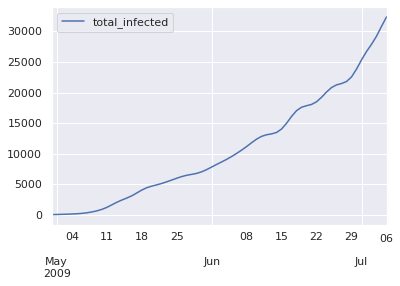

In [116]:
plt.figure()
df.total_infected.plot(label='total_infected')
plt.legend()
plt.show()

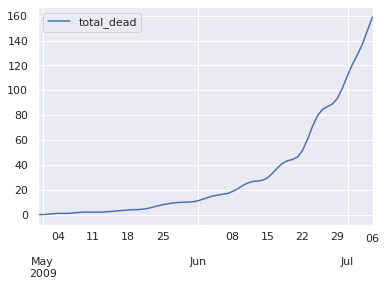

In [117]:
plt.figure()
df.total_dead.plot(label='total_dead')
plt.legend()
plt.show()

# Set fixed params

In [143]:
population = 306.8 * 10e6
i0 = df.iloc[0].total_infected
gamma = 1/3.38
rho = 1/3.38

In [144]:
class SIRH1N1(SIROneStain):
    def get_fit_params(self):
        params = Parameters()
        params.add("population", value=self.population, vary=False)
        params.add("beta", value=1.2, min=0, max=10, vary=True)
        params.add("gamma", value=gamma, min=0, max=1, vary=False)
        params.add("alpha", value=0.018, min=0, max=0.2, vary=True)
        params.add("rho", value=rho, min=0, max=1, vary=False)
        params.add("i0", value=i0, vary=False)
        return params

In [145]:
df.iloc[0]

total_infected    44.666667
total_dead         0.000000
Name: 2009-04-30 00:00:00, dtype: float64

In [146]:
model = SIRH1N1(population)
model.fit(df)

S, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

1.1933300391913237

In [147]:
result

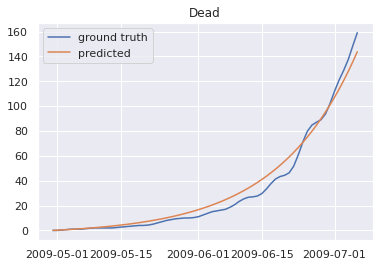

In [148]:
plt.figure()
plt.plot(df.index, df['total_dead'], label='ground truth')
plt.plot(df.index, D, label='predicted')
plt.legend()
plt.title('Dead')
plt.show()

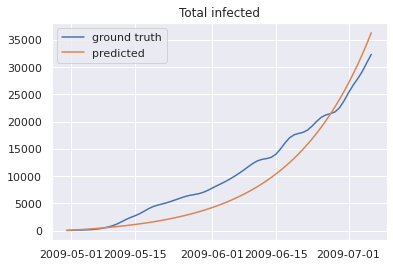

In [149]:
plt.figure()
plt.plot(df.index, df['total_infected'], label='ground truth')
plt.plot(df.index, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

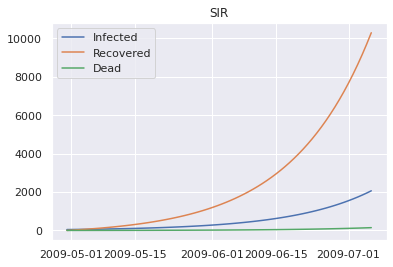

In [153]:
plt.figure()
plt.plot(df.index, I, label='Infected')
plt.plot(df.index, R, label='Recovered')
plt.plot(df.index, D, label='Dead')
plt.legend()
plt.title('SIR')
plt.show()